# 4. ResNet

## Import packages

In [551]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


# Dataset1: Color Classification


## Load data
The datasets have contained about 80 images for training datasets for whole color classes and 90 images for the test set. colors which are prepared for this application is y yellow, black, white, green, red, orange, blue a and violet. In this implementation, basic colors are preferred for classification. and created a dataset containing images of these basic colors. The dataset also includes masks for all images. we create these masks by binarizing the image. we did the masking on the images I collected and painted the pixels belonging to the class color to white and the remaining pixels to the black color.

Reference: https://www.kaggle.com/datasets/ayanzadeh93/color-classification

1. set path, categories, create_training_data function

In [502]:
DATADIR = './dataset1/ColorClassification'
CATEGORIES = ['orange','Violet','red','Blue','Green','Black','Brown','White']
# labels: 0-7
IMG_SIZE = 224
def create_training_data(training_data=[]):
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path,img)
            # img_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            training_data.append([img_path,class_num])

./dataset1/ColorClassification\orange


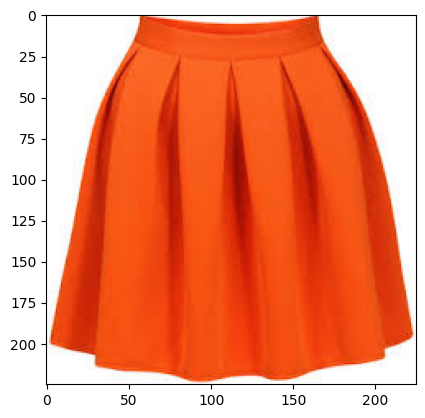

In [503]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        print(path)
        plt.imshow(img_array)
        plt.show()
        break
    break

In [504]:
training_data=[]
create_training_data(training_data) 
X = []
y = []
for categories, label in training_data:
    X.append(categories)
    y.append(label)

./dataset1/ColorClassification\red\4.jpg


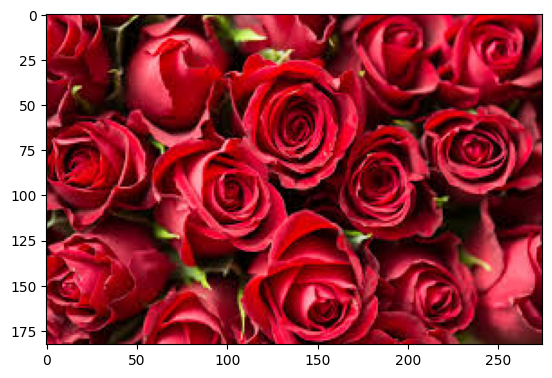

In [505]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10, train_size=0.8)
for img in x_test:
    img_path = img
    print(img_path)
    img_array=cv2.imread(img_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_array)
    plt.show()
    break

## Dataset and DataLoader

In [506]:
class color_Dataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.y = y
    
    def __getitem__(self, index):
        label = int(self.y[index])
        img = Image.open(self.data[index])
        
        # channel should be 3
        if img.mode != "RGB":
            img = img.convert('RGB')

        norm_mean = [0.485, 0.456, 0.406]
        norm_std = [0.229, 0.224, 0.225]

        img_transform = transforms.Compose([
            transforms.Resize((100, 100)),# resize
            transforms.ToTensor(), # turn into tensor
            transforms.Normalize(norm_mean, norm_std), # normalize
        ])
        img = img_transform(img)
        return torch.FloatTensor(img), label
    def __len__(self):
        return len(self.data)

In [507]:
DATADIR = './dataset1/ColorClassification'
CATEGORIES = ['orange','Violet','red','Blue','Green','Black','Brown','White']
IMG_SIZE = 100
def create_training_data():
    training_data=[]
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img))
            new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            training_data.append([new_array,class_num])
    return training_data

In [508]:
# split train & val (7:3)
train_size = len(x_train)
target = int(train_size*0.15)

x_train_data = x_train[target:train_size-target]
y_train_data = y_train[target:train_size-target]
x_val_data = x_train[:target]
x_val_data += x_train[train_size-target:]
y_val_data = y_train[:target]
y_val_data += y_train[train_size-target:]

print(len(x_train_data), len(x_val_data))

train_ds = color_Dataset(x_train_data, y_train_data)
train_dl = DataLoader(train_ds, batch_size=8, num_workers=0, drop_last=False, shuffle=True)
val_ds = color_Dataset(x_val_data, y_val_data)
val_dl = DataLoader(val_ds, batch_size=8, num_workers=0, drop_last=False, shuffle=False)

test_ds = color_Dataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=8, num_workers=0, drop_last=False, shuffle=False)

x, y = train_ds[4]
print(x.shape, y)

print(len(train_dl), len(val_dl))

61 24
torch.Size([3, 100, 100]) 6
8 3


## Training

In [499]:
color_train_loss = []
color_val_loss = []
device = "cpu"
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
fc_feature = model.fc.in_features

# resnet18 default output: 1000
model.fc = nn.Linear(fc_feature, 8, bias=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    print("Epoch", epoch+1)
    model.train()
    loss_t = 0.0
    loss_v = 0.0
    t_ans = 0
    f_ans = 0
    for image, label in tqdm(train_dl):
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)

            if ans.item() == label[ind].item():
                t_ans += 1
            else:
                f_ans += 1
        
        labels = np.zeros((len(label), 8))
        for i, l in enumerate(label):
            labels[i][l] = 1
        labels = torch.from_numpy(labels)
        train_loss = loss_fn(pred, labels) 
        loss_t += train_loss.item()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    train_auc = t_ans / (t_ans + f_ans)
    print("train accuracy:", train_auc)
    color_train_loss.append(loss_t/len(train_dl))


    # val
    model.eval()
    t_ans = 0
    f_ans = 0
    for image, label in tqdm(val_dl):
        image = image.to(device)
        label = label.to(device)
        labels = np.zeros((len(label), 8))
        for i, l in enumerate(label):
            labels[i][l] = 1
        labels = torch.from_numpy(labels)
        pred = model(image)
        val_loss = loss_fn(pred, labels)
        loss_v += val_loss.item()

        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            if ans.item() == label[ind].item():
                t_ans += 1
            else:
                f_ans += 1

    val_auc = t_ans / (t_ans + f_ans)
    print("val accuracy:", val_auc)
    color_val_loss.append(loss_v/len(val_dl))  
    print(f'loss(train/val), {loss_t/len(train_dl)} / {loss_v/len(val_dl)}\n')


color_model = './models/color_model.pt'
torch.save(model.state_dict(), color_model)


Epoch 1


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train AUC: 0.3076923076923077


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


val AUC: 0.14285714285714285
loss(train/val), 2.076656277631576 / 5.821725411030153

Epoch 2


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


train AUC: 0.6410256410256411


100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


val AUC: 0.5714285714285714
loss(train/val), 0.9123209583319424 / 2.996740502926211

Epoch 3


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


train AUC: 0.7948717948717948


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


val AUC: 0.5
loss(train/val), 1.2185539477787513 / 1.8646969712281134

Epoch 4


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


train AUC: 0.6666666666666666


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


val AUC: 0.7857142857142857
loss(train/val), 1.3898406004089339 / 0.9213692967702324

Epoch 5


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train AUC: 0.5641025641025641


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


val AUC: 0.14285714285714285
loss(train/val), 1.1109186750146494 / 3.455073170984785

Epoch 6


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


train AUC: 0.7948717948717948


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


val AUC: 0.5714285714285714
loss(train/val), 0.531562347522205 / 1.1233173672808334

Epoch 7


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


train AUC: 0.7435897435897436


100%|██████████| 2/2 [00:00<00:00,  7.19it/s]


val AUC: 0.5
loss(train/val), 0.7757372125604889 / 1.2900790663576724

Epoch 8


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


train AUC: 0.8205128205128205


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


val AUC: 0.42857142857142855
loss(train/val), 0.44423974883933887 / 1.6520007022069574

Epoch 9


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


train AUC: 0.7948717948717948


100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


val AUC: 0.5
loss(train/val), 0.5620241451711211 / 1.6693111020649667

Epoch 10


100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


train AUC: 0.8974358974358975


100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

val AUC: 0.5714285714285714
loss(train/val), 0.4224334482163873 / 1.501095045619877



In [500]:
model = models.resnet18(num_classes=8)
model.to(device)
model.load_state_dict(torch.load(color_model))

with torch.no_grad():
    for image, labels in tqdm(test_dl):
        image = image.to(device)
        label = labels.to(device)
        pred = model(image)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            if ans.item() == label[ind].item():
                t_ans += 1
            else:
                f_ans += 1

    test_auc = t_ans / (t_ans + f_ans)
    print("test accuracy:", test_auc)
    
    

100%|██████████| 7/7 [00:01<00:00,  5.85it/s]

test AUC: 0.6176470588235294


In [531]:
# import torchvision.transforms as transforms
# from PIL import Image
# import os
# SAVEROOT = './dataset1/Aug_ColorClassification'
# def data_augmentation(image_path, save_dir):
#     save_dir = os.path.join(SAVEROOT, save_dir)
#     img = Image.open(image_path)
#     crop_size = 224
#     prob = 0.7
#     if min(img.size) < crop_size:
#         crop_size = min(img.size)

#     # crop & flip
#     img_transform = transforms.Compose([
#         transforms.RandomCrop(size=crop_size),
#         transforms.RandomHorizontalFlip(p=prob),
#         transforms.RandomVerticalFlip(p=prob),
#         transforms.ToTensor(),
#     ])
#     img_tensor = img_transform(img)
#     img_transformed = transforms.ToPILImage()(img_tensor)
#     img_transformed.save(save_dir)

## Load Augmentation Data

In [509]:
aug_data = []
AUGDIR = './dataset1/Aug_ColorClassification/'
for category in CATEGORIES:
    path = os.path.join(AUGDIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        # img_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        aug_data.append([img_path,class_num])
print(len(aug_data))


107


./dataset1/Aug_ColorClassification/orange


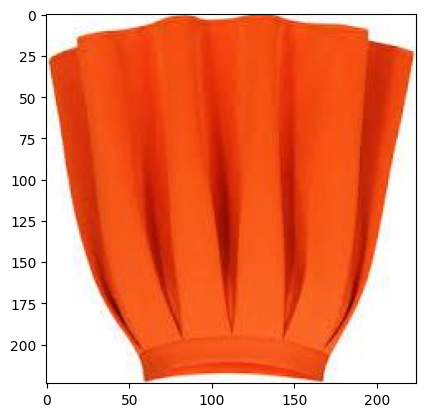

In [510]:
for category in CATEGORIES:
    path = os.path.join(AUGDIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        print(path)
        plt.imshow(img_array)
        plt.show()
        break
    break

In [521]:
# split train & val (7:3)
train_size = len(x_train)
target = int(train_size*0.15)

x_train_data = x_train[target:train_size-target]
y_train_data = y_train[target:train_size-target]
x_val_data = x_train[:target]
x_val_data += x_train[train_size-target:]
y_val_data = y_train[:target]
y_val_data += y_train[train_size-target:]



# add more data
for categories, label in aug_data:
    x_train_data.append(categories)
    y_train_data.append(label)

print(len(x_train_data), len(x_val_data), len(x_test))

train_ds = color_Dataset(x_train_data, y_train_data)
train_dl = DataLoader(train_ds, batch_size=16, num_workers=0, drop_last=False, shuffle=True)
val_ds = color_Dataset(x_val_data, y_val_data)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=0, drop_last=False, shuffle=False)

test_ds = color_Dataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=16, num_workers=0, drop_last=False, shuffle=False)

x, y = train_ds[4]
print(x.shape, y)

print(len(train_dl), len(val_dl))

168 24 22
torch.Size([3, 100, 100]) 6
11 2


## Training (with augmentation data)

In [523]:
aug_color_train_loss = []
aug_color_val_loss = []
device = "cpu"
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# model = models.resnet18()
fc_feature = model.fc.in_features

# resnet18 default output: 1000
model.fc = nn.Linear(fc_feature, 8, bias=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    print("Epoch", epoch+1, end=": ")
    model.train()
    loss_t = 0.0
    loss_v = 0.0
    t_ans = 0
    f_ans = 0
    for image, label in tqdm(train_dl):
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)

            if ans.item() == label[ind].item():
                t_ans += 1
            else:
                f_ans += 1
        
        labels = np.zeros((len(label), 8))
        for i, l in enumerate(label):
            labels[i][l] = 1
        labels = torch.from_numpy(labels)
        train_loss = loss_fn(pred, labels) 
        loss_t += train_loss.item()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_auc = t_ans / (t_ans + f_ans)
    print("train accuracy:", train_auc)
    aug_color_train_loss.append(loss_t/len(train_dl))

    # val
    model.eval()
    t_ans = 0
    f_ans = 0
    for image, label in tqdm(val_dl):
        image = image.to(device)
        label = label.to(device)
        labels = np.zeros((len(label), 8))
        for i, l in enumerate(label):
            labels[i][l] = 1
        labels = torch.from_numpy(labels)
        pred = model(image)
        val_loss = loss_fn(pred, labels)
        loss_v += val_loss.item()

        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            if ans.item() == label[ind].item():
                t_ans += 1
            else:
                f_ans += 1
    
    val_auc = t_ans / (t_ans + f_ans)
    print("val accuracy:", val_auc)
    aug_color_val_loss.append(loss_v/len(val_dl))  
    print(f'loss(train/val), {loss_t/len(train_dl)} / {loss_v/len(val_dl)}\n')

aug_color_model = './models/aug_color_model.pt'
torch.save(model.state_dict(), aug_color_model)


Epoch 1: 

100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


train accuracy: 0.4880952380952381


100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


val accuracy: 0.2916666666666667
loss(train/val), 1.6463668027761182 / 2.118651020282414

Epoch 2: 

100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


train accuracy: 0.6964285714285714


100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


val accuracy: 0.4166666666666667
loss(train/val), 1.179098298621095 / 10.74002155214373

Epoch 3: 

100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


train accuracy: 0.6964285714285714


100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


val accuracy: 0.75
loss(train/val), 1.0587061941879277 / 0.5786294283740787

Epoch 4: 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


train accuracy: 0.7619047619047619


100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


val accuracy: 0.6666666666666666
loss(train/val), 0.807458145149543 / 0.7833847707801169

Epoch 5: 

100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


train accuracy: 0.8392857142857143


100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


val accuracy: 0.8333333333333334
loss(train/val), 0.5258666446579396 / 0.9448241763914194

Epoch 6: 

100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


train accuracy: 0.7678571428571429


100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


val accuracy: 0.5833333333333334
loss(train/val), 0.8435463433729095 / 0.6484802364825555

Epoch 7: 

100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


train accuracy: 0.8273809523809523


100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


val accuracy: 0.9583333333333334
loss(train/val), 0.5636492400900948 / 0.18351694790237616

Epoch 8: 

100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


train accuracy: 0.8214285714285714


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


val accuracy: 0.875
loss(train/val), 0.5461880752266304 / 0.5189703517253292

Epoch 9: 

100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


train accuracy: 0.9047619047619048


100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


val accuracy: 0.9583333333333334
loss(train/val), 0.3478576800970139 / 0.1492956825331362

Epoch 10: 

100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


train accuracy: 0.9107142857142857


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

val accuracy: 0.9166666666666666
loss(train/val), 0.2885869589012641 / 0.20818667608546093



## Testing

In [524]:
model = models.resnet18(num_classes=8)
model.to(device)
model.load_state_dict(torch.load(aug_color_model))
model.eval()

with torch.no_grad():
    for image, labels in tqdm(test_dl):
        image = image.to(device)
        label = labels.to(device)
        pred = model(image)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            if ans.item() == label[ind].item():
                t_ans += 1
            else:
                f_ans += 1
    
    test_auc = t_ans / (t_ans + f_ans)
    print("test accuracy:", test_auc)

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

test accuracy: 0.9130434782608695


# Dataset3: my cat or not my cat

## Load Data

In [541]:
CATEGORIES = ['my_cat', 'not_my_cat']
DATADIR = './dataset3'

def get_dataset():
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    with open('./dataset3/train.csv', newline='') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            filename, label = row
            filename = os.path.join("train", filename)
            x_train.append(filename)
            y_train.append(label)
    csv_file.close()

    with open('./dataset3/test.csv', newline='') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            filename, label = row
            filename = os.path.join("test", filename)
            x_test.append(filename)
            y_test.append(label)
    csv_file.close()
    return x_train, y_train, x_test, y_test


In [542]:
x_train, y_train, x_test, y_test = get_dataset() 

## Show image (my cat / not my cat)

./dataset3\train\LINE_ALBUM_my_cat_230309_5.jpg


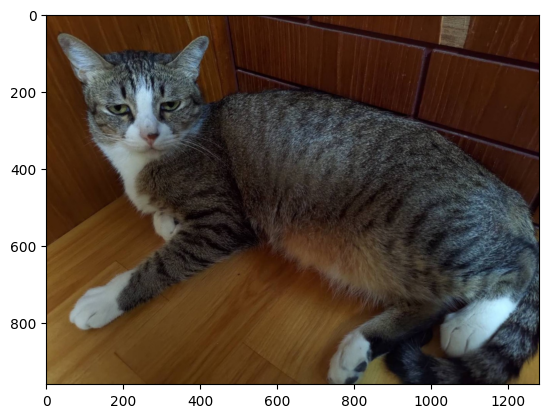

./dataset3\train\LINE_ALBUM_not_my_cat_230309_54.jpg


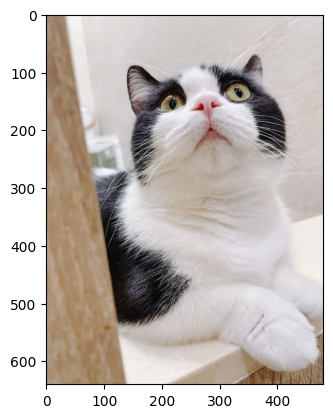

In [543]:
img = x_train[0]
img_path = os.path.join(DATADIR, img)
print(img_path)
img_array=cv2.imread(img_path)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array)
plt.show()

img = x_train[-1]
img_path = os.path.join(DATADIR, img)
print(img_path)
img_array=cv2.imread(img_path)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array)
plt.show()

## Dataset and DataLoader

In [544]:
class catDataset(Dataset):
    def __init__(self, data, y, root, train=True):
        self.data = data
        self.root = root
        self.y = y
        self.train = train
    
    def __getitem__(self, index):
        filename = self.data[index]
        label = int(self.y[index])
        img = Image.open(f"{self.root}/{filename}")
        norm_mean = [0.485, 0.456, 0.406]
        norm_std = [0.229, 0.224, 0.225]
        if self.train:
            img_transform = transforms.Compose([
                transforms.Resize((224, 224)),# resize
                transforms.ToTensor(), # turn into tensor
                transforms.Normalize(norm_mean, norm_std), # normalize
                transforms.RandomHorizontalFlip() # random horizontal flip
            ])
        else:
                img_transform = transforms.Compose([
                transforms.Resize((224, 224)),# resize
                transforms.ToTensor(), # turn into tensor
                transforms.Normalize(norm_mean, norm_std), # normalize
            ])
        img = img_transform(img)

        # lab = label_encode(label)
        return torch.FloatTensor(img), label
    def __len__(self):
        return len(self.data)

In [545]:
train_data = []
val_data = []

# split train & val (7:3)
train_size = len(x_train)
target = int(train_size*0.15)

x_train_data = x_train[target:train_size-target]
y_train_data = y_train[target:train_size-target]
x_val_data = x_train[:target]
x_val_data += x_train[train_size-target:]
y_val_data = y_train[:target]
y_val_data += y_train[train_size-target:]

print(len(x_train_data), len(x_val_data), len(x_test))

train_ds = catDataset(x_train_data, y_train_data, root='./dataset3/')
train_dl = DataLoader(train_ds, batch_size=16, num_workers=0, drop_last=False, shuffle=True)
val_ds = catDataset(x_val_data, y_val_data, root='./dataset3/')
val_dl = DataLoader(val_ds, batch_size=16, num_workers=0, drop_last=False, shuffle=False)
test_ds = catDataset(x_test, y_test, root='./dataset3/')
test_dl = DataLoader(test_ds, batch_size=16, num_workers=0, drop_last=False, shuffle=False)

x, y = train_ds[0]
print(x.shape, y)
print(len(train_dl), len(val_dl))

132 54 81
torch.Size([3, 224, 224]) 1
9 4


## Training

In [546]:
cat_train_loss = []
cat_val_loss = []
device = "cpu"
model = models.resnet18()
fc_feature = model.fc.in_features

# resnet18 default output: 1000
model.fc = nn.Linear(fc_feature, 2, bias=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

train_loss_list = []
val_loss_list = []
in_epoch = 0
for epoch in range(10):
    print("Epoch", epoch+1, end=": ")
    model.train()
    loss_t = 0.0
    loss_v = 0.0
    actual = []
    predicted = []
    for image, label in tqdm(train_dl):
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            predicted.append(ans.item())
        
        labels = np.zeros((len(label), 2))
        for i, l in enumerate(label):
            labels[i][l] = 1
            actual.append(l)
        labels = torch.from_numpy(labels)
        train_loss = loss_fn(pred, labels) 
        loss_t += train_loss.item()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fp) > 0 else 0
    F1 = 2 / ((1/precision) + (1/recall)) if precision > 0 and recall > 0 else 0
    print("Train:")
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("F1:", F1)

    cat_train_loss.append(loss_t/len(train_dl))

    # val
    model.eval()
    actual = []
    predicted = []
    for image, label in tqdm(val_dl):
        image = image.to(device)
        label = label.to(device)
        labels = np.zeros((len(label), 2))
        for i, l in enumerate(label):
            labels[i][l] = 1
            actual.append(l)
        labels = torch.from_numpy(labels)
        pred = model(image)
        val_loss = loss_fn(pred, labels)
        loss_v += val_loss.item()
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            predicted.append(ans.item())
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fp) > 0 else 0
    F1 = 2 / ((1/ precision) + (1/ recall)) if precision > 0 and recall > 0 else 0
    print("Validation:")
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("F1:", F1)

    cat_val_loss.append(loss_v/len(val_dl))  
    print(f'loss(train/val), {loss_t/len(train_dl)} / {loss_v/len(val_dl)}')

cat_model = './models/cat_model.pt'
torch.save(model.state_dict(), cat_model)


Epoch 1: 

100%|██████████| 9/9 [00:21<00:00,  2.40s/it]


Train:
accuracy: 0.6439393939393939
precision: 0.5714285714285714
recall: 0.7017543859649122
F1: 0.6299212598425197


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Validation:
accuracy: 0.5
precision: 0
recall: 0
F1: 0
loss(train/val), 1.0197238312565433 / 40385.20690917969
Epoch 2: 

100%|██████████| 9/9 [00:18<00:00,  2.08s/it]


Train:
accuracy: 0.7803030303030303
precision: 0.7333333333333333
recall: 0.7719298245614035
F1: 0.7521367521367521


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Validation:
accuracy: 0.5
precision: 0
recall: 0
F1: 0
loss(train/val), 0.4671338103445224 / 112.29570750519633
Epoch 3: 

100%|██████████| 9/9 [00:18<00:00,  2.02s/it]


Train:
accuracy: 0.8939393939393939
precision: 0.9056603773584906
recall: 0.8421052631578947
F1: 0.8727272727272726


100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


Validation:
accuracy: 0.6111111111111112
precision: 1.0
recall: 0.2222222222222222
F1: 0.36363636363636365
loss(train/val), 0.29763137652841104 / 12.183028885301608
Epoch 4: 

100%|██████████| 9/9 [00:18<00:00,  2.04s/it]


Train:
accuracy: 0.8939393939393939
precision: 0.864406779661017
recall: 0.8947368421052632
F1: 0.8793103448275862


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Validation:
accuracy: 0.7222222222222222
precision: 0.9285714285714286
recall: 0.48148148148148145
F1: 0.6341463414634145
loss(train/val), 0.2657138712870977 / 3.0359704963174363
Epoch 5: 

100%|██████████| 9/9 [00:17<00:00,  1.98s/it]


Train:
accuracy: 0.8939393939393939
precision: 0.8771929824561403
recall: 0.8771929824561403
F1: 0.8771929824561403


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Validation:
accuracy: 0.7592592592592593
precision: 0.8888888888888888
recall: 0.5925925925925926
F1: 0.7111111111111111
loss(train/val), 0.31199458618901876 / 0.8288865327872501
Epoch 6: 

100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


Train:
accuracy: 0.8333333333333334
precision: 0.7464788732394366
recall: 0.9298245614035088
F1: 0.828125


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Validation:
accuracy: 0.8148148148148148
precision: 0.9473684210526315
recall: 0.6666666666666666
F1: 0.782608695652174
loss(train/val), 0.3815690496137007 / 0.3532066953061322
Epoch 7: 

100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


Train:
accuracy: 0.8409090909090909
precision: 0.95
recall: 0.6666666666666666
F1: 0.7835051546391754


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Validation:
accuracy: 0.6851851851851852
precision: 0.6136363636363636
recall: 1.0
F1: 0.7605633802816901
loss(train/val), 0.4401151203694205 / 0.6060460663563086
Epoch 8: 

100%|██████████| 9/9 [00:18<00:00,  2.02s/it]


Train:
accuracy: 0.8712121212121212
precision: 0.8571428571428571
recall: 0.8421052631578947
F1: 0.8495575221238937


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Validation:
accuracy: 0.8333333333333334
precision: 0.8461538461538461
recall: 0.8148148148148148
F1: 0.830188679245283
loss(train/val), 0.2954619586553858 / 0.3918242438599104
Epoch 9: 

100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


Train:
accuracy: 0.9166666666666666
precision: 0.8833333333333333
recall: 0.9298245614035088
F1: 0.9059829059829061


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Validation:
accuracy: 0.8703703703703703
precision: 0.7941176470588235
recall: 1.0
F1: 0.8852459016393441
loss(train/val), 0.240998693507941 / 0.27480927950038375
Epoch 10: 

100%|██████████| 9/9 [00:18<00:00,  2.03s/it]


Train:
accuracy: 0.8560606060606061
precision: 0.8653846153846154
recall: 0.7894736842105263
F1: 0.8256880733944955


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

Validation:
accuracy: 0.8518518518518519
precision: 0.8064516129032258
recall: 0.9259259259259259
F1: 0.8620689655172413
loss(train/val), 0.2734431467889951 / 0.32293326229694114


In [549]:
pre_cat_train_loss = []
pre_cat_val_loss = []
device = "cpu"
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
fc_feature = model.fc.in_features

# resnet18 default output: 1000
model.fc = nn.Linear(fc_feature, 2, bias=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

train_loss_list = []
val_loss_list = []
in_epoch = 0
for epoch in range(10):
    print("Epoch", epoch+1, end=": ")
    model.train()
    loss_t = 0.0
    loss_v = 0.0
    actual = []
    predicted = []
    for image, label in tqdm(train_dl):
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            predicted.append(ans.item())
        
        labels = np.zeros((len(label), 2))
        for i, l in enumerate(label):
            labels[i][l] = 1
            actual.append(l)
        labels = torch.from_numpy(labels)
        train_loss = loss_fn(pred, labels) 
        loss_t += train_loss.item()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fp) > 0 else 0
    F1 = 2 / ((1/precision) + (1/recall)) if precision > 0 and recall > 0 else 0
    print("Train:")
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("F1:", F1)

    cat_train_loss.append(loss_t/len(train_dl))

    # val
    model.eval()
    actual = []
    predicted = []
    for image, label in tqdm(val_dl):
        image = image.to(device)
        label = label.to(device)
        labels = np.zeros((len(label), 2))
        for i, l in enumerate(label):
            labels[i][l] = 1
            actual.append(l)
        labels = torch.from_numpy(labels)
        pred = model(image)
        val_loss = loss_fn(pred, labels)
        loss_v += val_loss.item()
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            predicted.append(ans.item())
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fp) > 0 else 0
    F1 = 2 / ((1/ precision) + (1/ recall)) if precision > 0 and recall > 0 else 0
    print("Validation:")
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("F1:", F1)

    cat_val_loss.append(loss_v/len(val_dl))  
    print(f'loss(train/val), {loss_t/len(train_dl)} / {loss_v/len(val_dl)}')

pretrain_cat_model = './models/pretrain_cat_model.pt'
torch.save(model.state_dict(), pretrain_cat_model)


Epoch 1: 

100%|██████████| 9/9 [00:20<00:00,  2.25s/it]


Train:
accuracy: 0.5909090909090909
precision: 0.5333333333333333
recall: 0.42105263157894735
F1: 0.47058823529411764


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Validation:
accuracy: 0.5
precision: 0
recall: 0
F1: 0
loss(train/val), 1.6686234507139146 / 327278.091796875
Epoch 2: 

100%|██████████| 9/9 [00:18<00:00,  2.06s/it]


Train:
accuracy: 0.6363636363636364
precision: 0.5652173913043478
recall: 0.6842105263157895
F1: 0.6190476190476191


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Validation:
accuracy: 0.7592592592592593
precision: 0.6842105263157895
recall: 0.9629629629629629
F1: 0.8
loss(train/val), 0.8286771893633416 / 413.13888200124103
Epoch 3: 

100%|██████████| 9/9 [00:23<00:00,  2.65s/it]


Train:
accuracy: 0.5984848484848485
precision: 0.5303030303030303
recall: 0.6140350877192983
F1: 0.5691056910569106


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Validation:
accuracy: 0.5
precision: 0
recall: 0
F1: 0
loss(train/val), 0.6752660996171215 / 14.567918857628722
Epoch 4: 

100%|██████████| 9/9 [00:23<00:00,  2.59s/it]


Train:
accuracy: 0.5909090909090909
precision: 0.5194805194805194
recall: 0.7017543859649122
F1: 0.5970149253731343


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Validation:
accuracy: 0.5
precision: 0
recall: 0
F1: 0
loss(train/val), 0.724333601722263 / 2.47919760954319
Epoch 5: 

100%|██████████| 9/9 [00:25<00:00,  2.78s/it]


Train:
accuracy: 0.6818181818181818
precision: 0.7272727272727273
recall: 0.42105263157894735
F1: 0.5333333333333333


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Validation:
accuracy: 0.8518518518518519
precision: 0.8518518518518519
recall: 0.8518518518518519
F1: 0.851851851851852
loss(train/val), 0.6750804053762948 / 0.713371463799073
Epoch 6: 

100%|██████████| 9/9 [00:23<00:00,  2.61s/it]


Train:
accuracy: 0.6287878787878788
precision: 0.5869565217391305
recall: 0.47368421052631576
F1: 0.5242718446601942


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Validation:
accuracy: 0.7777777777777778
precision: 0.7272727272727273
recall: 0.8888888888888888
F1: 0.8
loss(train/val), 0.5306358258580283 / 0.4628564445035909
Epoch 7: 

100%|██████████| 9/9 [00:23<00:00,  2.63s/it]


Train:
accuracy: 0.8181818181818182
precision: 0.8
recall: 0.7719298245614035
F1: 0.7857142857142856


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Validation:
accuracy: 0.7777777777777778
precision: 0.7419354838709677
recall: 0.8518518518518519
F1: 0.7931034482758622
loss(train/val), 0.4687233133478258 / 0.4518183406451352
Epoch 8: 

100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


Train:
accuracy: 0.9090909090909091
precision: 0.8688524590163934
recall: 0.9298245614035088
F1: 0.8983050847457628


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Validation:
accuracy: 0.8148148148148148
precision: 0.8148148148148148
recall: 0.8148148148148148
F1: 0.8148148148148148
loss(train/val), 0.2708159727907916 / 0.4375585825659982
Epoch 9: 

100%|██████████| 9/9 [00:22<00:00,  2.53s/it]


Train:
accuracy: 0.8863636363636364
precision: 0.9038461538461539
recall: 0.8245614035087719
F1: 0.8623853211009175


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Validation:
accuracy: 0.8148148148148148
precision: 0.7931034482758621
recall: 0.8518518518518519
F1: 0.8214285714285714
loss(train/val), 0.6653476461127197 / 0.4407102776680958
Epoch 10: 

100%|██████████| 9/9 [00:18<00:00,  2.03s/it]


Train:
accuracy: 0.8333333333333334
precision: 0.7333333333333333
recall: 0.9649122807017544
F1: 0.8333333333333333


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

Validation:
accuracy: 0.7962962962962963
precision: 0.7857142857142857
recall: 0.8148148148148148
F1: 0.8
loss(train/val), 0.36221497189604196 / 0.5752567282914098


## Testing

In [553]:
model = models.resnet18(num_classes=2)
model.to(device)
model.load_state_dict(torch.load(cat_model))
model.eval()

with torch.no_grad():
    actual = []
    predicted = []
    for image, labels in tqdm(test_dl):
        image = image.to(device)
        label = labels.to(device)
        pred = model(image)
        for i, l in enumerate(label):
            actual.append(l)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            predicted.append(ans.item())
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fp) > 0 else 0
    F1 = 2 / ((1/ precision) + (1/ recall)) if precision > 0 and recall > 0 else 0
    print("Test:")
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("F1:", F1)

print("\n========\n")
print("Pretrained model")
model = models.resnet18(num_classes=2)
model.to(device)
model.load_state_dict(torch.load(pretrain_cat_model))
model.eval()

with torch.no_grad():
    actual = []
    predicted = []
    for image, labels in tqdm(test_dl):
        image = image.to(device)
        label = labels.to(device)
        pred = model(image)
        for i, l in enumerate(label):
            actual.append(l)
        for ind, value in enumerate(pred):
            ans = torch.argmax(value)
            predicted.append(ans.item())
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fp) > 0 else 0
    F1 = 2 / ((1/ precision) + (1/ recall)) if precision > 0 and recall > 0 else 0
    print("Test:")
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("F1:", F1)
    

100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Test:
accuracy: 0.8641975308641975
precision: 0.7954545454545454
recall: 0.9459459459459459
F1: 0.8641975308641976


Pretrained model


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]

Test:
accuracy: 0.7530864197530864
precision: 0.7073170731707317
recall: 0.7837837837837838
F1: 0.7435897435897435
